In [1]:
from utils import set_pyplot_params
set_pyplot_params()

# Confronto

Questo capitolo introduce le distribuzioni congiunte, che rappresenta uno strumento per lavorare con le distribuzioni con più di una variabile.

Le useremo per risolvere un semplice problema per poi passare a risolvere dei reali problemi.
Il reale problema è quello di valutare i giocatori di scacchi, o i partecipanti si altre competizioni, basandosi sui risultati delle partite.

Per costruire le distribuzioni congiunte e calcolare le verosomiglianze per questi problemi, useremo il prodotto vettoriale e operazioni simili.

E ora partiamo.

## Operazioni Outer

Molte operazioni utili possono essere espresse come "prodotto esterno" di due sequenze, o tramite altri tipi di operazioni "esterne".

Supponiamo di avere due sequenze come `x` e `y`:

In [2]:
x = [1, 3, 5]
y = [2, 4]

Il prodotto esterno di queste sequenze è un array che contiene il prodotto di ogni coppia di valori,uno per ogni sequenza.
Ci sono molti modi per calcolare il prodotto esterno ma penso che una delle più versatili è la "mesh grid".

NumPy provvede una funzione chiamata `meshgrid`che calcola quanto richiesto. Se usiamo queste due sequenze, otteniamo questi due array

In [3]:
import numpy as np

X, Y = np.meshgrid(x, y)

Il primo array contiene le copie di `x` sistemato in righe, con le stesso numero di righe di `y`.

In [4]:
X

array([[1, 3, 5],
       [1, 3, 5]])

La stessa cosa vale per `y`.

In [5]:
Y

array([[2, 2, 2],
       [4, 4, 4]])

Visto che ora i due array hanno la stessa dimensione, possiamo usare questi due array per operazioni aritmetiche come la moltiplicazione.

In [6]:
X * Y

array([[ 2,  6, 10],
       [ 4, 12, 20]])

Il risultato del prodotto esterno di `x` e `y`.
Possiamo vederlo molto chiaramente se lo mettimo in un `DataFrame`:

In [7]:
import pandas as pd

df = pd.DataFrame(X * Y, columns=x, index=y)
df

,1,3,5
2,2,6,10
4,4,12,20


I valori di `x` appaiono come nomi di colonna; mentre i valori di `y` appaiono come etichette di riga.
Ogni elemento è il prodotto del valore di `x` e di un valore di  `y`.

Possiamo usare la griglia mesh per calcolare queste operazioni, come la somma esterna che contiene la somma degli elementi da `x` e degli elementi di `y`.



In [8]:
X + Y

array([[3, 5, 7],
       [5, 7, 9]])

Possiamo anche usare il confronto per comparare gli elementi di x e di y.

In [9]:
X > Y

array([[False,  True,  True],
       [False, False,  True]])

Il risultato è un array di valori booleani.
Potrebbe non essere ancora ovvio il perchè queste operazioni sia utile, ma lo vedreme più avanti. 
Con questo siamo pronti per affrontare un nuovo problema Bayesiano.

## Quanto è alto A?

Supponiamo che io scelga due persone dalla popolazione dei maschi adulti degli U.S.; che chiameremo A e B. Se vediamo che A è più alto di B, quanto è alto A?

Per rispondere a questa domanda:

1. Useremo le informazioni di fondo circa l'altezza degli uomini negli U.S. per creare una distribuzione a priori di altezze, 
2. Andremo a costruire una distribuzione a priori di altezze di A e B (e spiegheremo cosa sia),
3. Poi aggiorneremo la distribuzione a priori con A più alto e
4. Per la distribuzione a posteriori estrarremo la distribuzione a posteriori della altezza di A.




In [10]:
mean = 178
qs = np.arange(mean-24, mean+24, 0.5)

Scipy fornisce una funzione chiamata `norm` che rappresenta una distribuzione normale con una certa media e una deviazione standard, con il metodo `pdf`, che valuta la densità di probabilità della distribuzione normale:



In [11]:
from scipy.stats import norm

std = 7.7
ps = norm(mean, std).pdf(qs)

Le densità di probabilità non sono probabilità ma se le mettiamo in un oggetto Pmf e lo normalizziamo, il risultato è una discreta approssimazione di una distribuzione normale.



In [12]:
from distribution import Pmf

prior = Pmf(ps, qs)
prior.normalize()

1.9963309462450582

Qui come si presenta.

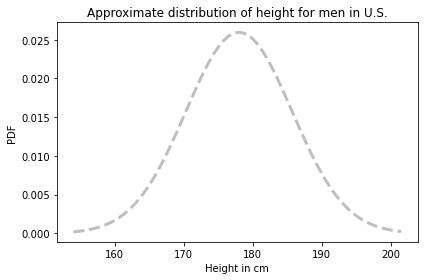

In [13]:
from utils import decorate

prior.plot(style='--', color='C5')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Approximate distribution of height for men in U.S.')

Questa distribuzione rappresenta su cosa crediamo circa le altezze di `A` e `B` prima di prendere in considerazione i dati che indicano che `A` è più alto.


## Distribuzione congiunta

Il prossimo passo è quello di costruire una distribuzione che rappresenta la probabiltià di ogni coppia di altezze, che è chiamato distribuzione congiunta. Gli elementi di una distribuzione congiunta sono:

$$P(A_x~\mathrm{e}~B_y)$$

che è la probabilità che `A` sia alto $x$ cm e  `B` sia alto $y$ cm, per tutti i valori di $x$ e $y$.
A questo punto tutto quello che sappiamo circa `A` e `B` è che questi sono maschi residenti negli stati uniti e le loro altezze sono indipendenti, conoscere l'altezza di `A` non ci da informazioi circa l'altezza di `B`.

In questo caso, possiamo calcolare le probabilità congiunte in questo modo:
$$P(A_x~\mathrm{e}~B_y) = P(A_x)~P(B_y)$$

Ogni probabilità congiunta è il prodotto di un elemento della distribuzione di `x` e di un elemento della distribuzione di `y`.
Dunque se abbiamo degli oggetti  `Pmf` che rappresentano le altezze di `A` e `B`, possiamo calcolare la distribuzione congiunta semplicemente calcolando il prodotto esterno in ogni `Pmf`.

La seguente funzione usa due oggetti `Pmf` e ritorna un oggetto `DataFrame` che rappresenta una distrbuzione congiunta.

In [14]:
def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

I nomi delle colonne sono le quantità presenti in `pmf1`; mentre nelle etichette di riga troviamo le quantità di `pmf2`.
In questo esempio le distribuzioni a propri di `A` e `B` sono le stesse, dunque possiamo calcolare la distribuzione congiunta a priori in questo modo:

In [15]:
joint = make_joint(prior, prior)
joint.shape

(96, 96)

Il risultato è un `DataFrame` con tutte le possibili altezze di `A` sulle colonne e le altezze di `B` sulle righe, e le probabilità congiunte di tutti gli elementi.

Se le distribuzioni a priori sono normalizzate anche la distribuzione congiunta a priori è normalizzata.

In [16]:
joint.to_numpy().sum()

1.0

abbiamo trasformato il dataframe in un array numpy perchè altrimenti otterremo una serie di somme di tutte le righe

In [17]:
series = joint.sum()
series.shape

(96,)

## Visualizzare la distribuzione congiunta

La seguente funzione usa `pcolormesh` per visualizzare la distribuzione congiunta. 

In [18]:
import matplotlib.pyplot as plt

def plot_joint(joint, cmap='Blues'):
    """Plot a joint distribution with a color mesh."""
    vmax = joint.to_numpy().max() * 1.1
    plt.pcolormesh(joint.columns, joint.index, joint, 
                   cmap=cmap,
                   vmax=vmax,
                   shading='nearest')
    plt.colorbar()
    
    decorate(xlabel='A height in cm',
             ylabel='B height in cm')

Vediamo come si visualizza questa distribuzione.

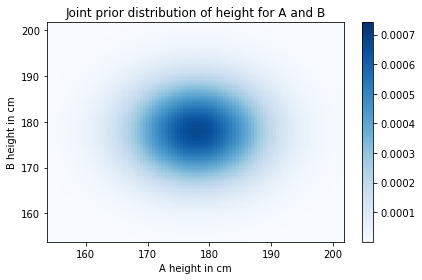

In [19]:
plot_joint(joint)
decorate(title='Joint prior distribution of height for A and B')

Come ci si aspetta, la probabilità è alta (scura) vicino la media e cala velocemente lontano da essa.
Un altro sistema di visualizzare la distribuzione congiunta è tramite i contorni.

In [20]:
def plot_contour(joint):
    """Plot a joint distribution with a contour."""
    plt.contour(joint.columns, joint.index, joint,
                linewidths=2)
    decorate(xlabel='A height in cm',
             ylabel='B height in cm')

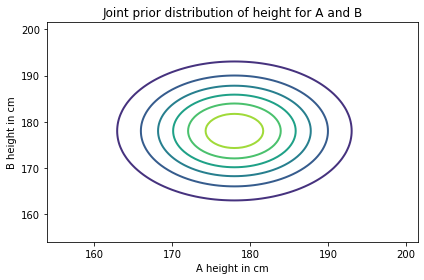

In [21]:
plot_contour(joint)
decorate(title='Joint prior distribution of height for A and B')

Ogni linea rappresenta un livello di egual probabilità.


## Aspettativa

Ora abbiamo una distribuzione congiunta a priori, possiamo aggiornare la distribuzione con il dato `A` è più grande di`B`.
Ogni elemento nella distribuzione congiunta rappresenta una ipotesi circa l'altezza di `A` e `B`.

Per calcolare la verosomiglianza di ogni coppia di quantità possiamo estrarre i nomi delle colonne e le etichette delle righe a priori, così: 

In [22]:
x = joint.columns
y = joint.index

Usiamo questo per calcolare la griglia mesh

In [23]:
X, Y = np.meshgrid(x, y)

Se compariamo `X` e `Y`, il risultato è un array Booleano

In [24]:
A_taller = (X > Y)
A_taller.dtype

dtype('bool')

Per caricare le verosomiglianze, useremo `np.where` per creare un array con il valore 1 quando A_taller è True 0 altrimenti.

In [25]:
a = np.where(A_taller, 1, 0)

Per visualizzare questo array di verosomiglianze, metteremo in un `DataFrame` con i valori di `x` come nomi di colonna e `y` come etichette di riga. 

In [26]:
likelihood = pd.DataFrame(a, index=x, columns=y)

Qui come viene visualizzato:

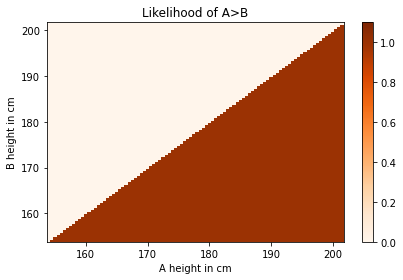

In [27]:
plot_joint(likelihood, cmap='Oranges')
decorate(title='Likelihood of A>B')

La verosomiglianza dei dati è 1 dove `X > Y` e 0 altrimenti.

## L'aggiornamento

Abbiamo una distribuzione a priori, abbiamo una funzione di verosomiglianza, e siamo pronti per l'aggiornamento. Come al solito la distribuzione a posteriori è il prodotto della distribuzione a priori e verosomiglianza.



In [28]:
posterior = joint * likelihood

Usiamo la seguente funzione per normalizzare la distribuzione a posteriori:

In [29]:
def normalize(joint):
    """Normalize a joint distribution."""
    prob_data = joint.to_numpy().sum()
    joint /= prob_data
    return prob_data

In [30]:
normalize(posterior)

0.49080747821526977

e qui il risultato.

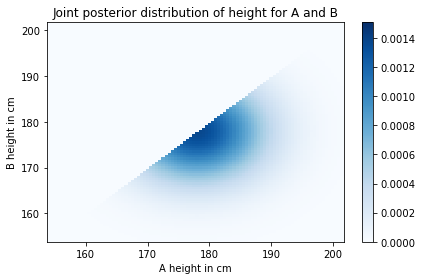

In [31]:
plot_joint(posterior)
decorate(title='Joint posterior distribution of height for A and B')

Tutte le coppie dove `B` è più grande `A` sono state eliminate. Il resto della distribuzione a posteriori tranne il fatto di essere renormalizzati.

## Distribuzioni marginali

La distibuzione a posteriori rappresenta cosa le nostre credenze circa l'altezza di `A` e `B` date la distribuzioni a priori e l'informazione che `A` è più alto.   
Per questa distribuzione congiunta, possiamo calcolare la distribuzione a posteriori di `A` e `B`. Per vedere come partiamo con un problema semplice.
Supponiamo di voler sapere la probabilità che `A`  è alto 180 cm. Possiamo scegliere la colonna della distribuzione congiunta dove `x=180`.

In [32]:
column = posterior[180]
column.head()

154.0    0.000010
154.5    0.000013
155.0    0.000015
155.5    0.000019
156.0    0.000022
Name: 180.0, dtype: float64

Questa colonna contiene le probabilità per tutti i casi dove `x=180`; se sommiamo tutti i valori otteniamo la probabilità totale che `A` sia alto 180 cm.

In [33]:
column.sum()

0.03017221271570807

Che rappresents circa il 3%.
Ora, per avere una distribuzione a posteriori di `A`, possiamo sommare tutte le colonne in questo modo:

In [34]:
column_sums = posterior.sum(axis=0)
column_sums.head()

154.0    0.000000e+00
154.5    1.012260e-07
155.0    2.736152e-07
155.5    5.532519e-07
156.0    9.915650e-07
dtype: float64

L'argomento `axis=0`significa che vogliamo sommare le colonne.
Il risultato è una serie che contiene ogni possibile altezza di `A` e le sue probabilità. In altre parole, è la distribuzione delle altezze di `A`.

Possiamo mettere questi valori dentro un oggetto `Pmf`:

In [35]:
marginal_A = Pmf(column_sums)

Possiamo estrarre la distribuzione di un singolo valore dalla distribuzione congiunta, il risultato è chiamato **distribuzione marginale**.

Il nome deriva da una visualizzazione che mostra la distribuzione congiunta nel mezzo e le distribuzioni marginali ai margini.
Qui la visualizzazione della distribuzione marginale di `A`:

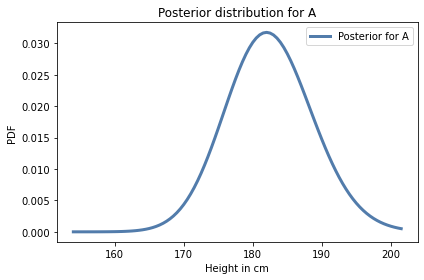

In [38]:
marginal_A.plot(label='Posterior for A')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Posterior distribution for A')

Similmente, possiamo ottenere la distribuzione a posteriori di `B` semplicemente sommando le righe e mettendo il risultato in un oggetto `Pmf`.

In [39]:
row_sums = posterior.sum(axis=1)
marginal_B = Pmf(row_sums)

Qui il grafico.

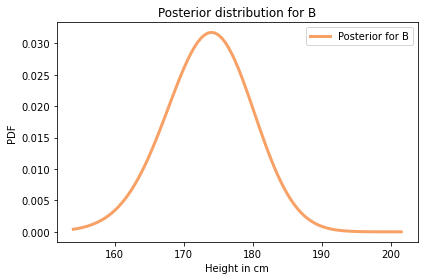

In [40]:
marginal_B.plot(label='Posterior for B', color='C1')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Posterior distribution for B')

creiamo una funzione che calcoli entrambi i valori.

In [41]:
def marginal(joint, axis):
    """Compute a marginal distribution."""
    return Pmf(joint.sum(axis=axis))

In [42]:
marginal_A = marginal(posterior, axis=0)
marginal_B = marginal(posterior, axis=1)

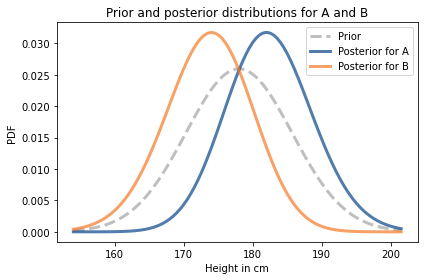

In [43]:
prior.plot(style='--', label='Prior', color='C5')
marginal_A.plot(label='Posterior for A')
marginal_B.plot(label='Posterior for B')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Prior and posterior distributions for A and B')

Come ci aspettiamo la distristribuzione a posteriori di `A` è spostata verso destra mentre la distribuzione a posteriori di `B` è spostata verso sinistra.

Possiamo riassumere i risultati calcolando le medie delle distribuzioni a posteriori:

In [44]:
prior.mean()

177.99516026921506

In [45]:
print(marginal_A.mean(), marginal_B.mean())

182.3872812342168 173.6028600023339


Basandosi sulla osservazione che `A` è più alto di `B`, siamo portati a credere che `A` è leggermente più alto della media e `B` leggermente più basso della stessa.


Le distribuzioni a posteriori sono leggermente più strette di quelle a priori. Possiamo quantificalo calcolando la deviazione standard.

In [46]:
prior.std()

7.624924796641578

In [47]:
print(marginal_A.std(), marginal_B.std())

6.270461177645469 6.280513548175111


La deviazione standard delle distribuzioni a posteriori sono più piccole, che significa che siamo più certi circa le altezze di 
`A` e `B` dopo averle comparati.

## Posteriori condizionali
Ora supponiamo di misurare `A` e di trovare che la sua altezza sia 170 cm. Cosa possiamo dire circa `B`?
Nella distribuzione congiunta, ogni colonna corrisponde un possibile valore di altezza di `A`.
Possiamo selezionare la colonna che corrisponde ad una altezza di 170 cm. 

In [48]:
column_170 = posterior[170]

Il risultato è un oggetto `Series` che rappresenta le possibili altezze di `B` e le relative verosomiglianze.
Queste verosomiglianze non sono normalizzate, possiamo normalizzarli in questo modo:

In [49]:
cond_B = Pmf(column_170)
cond_B.normalize()

0.004358061205454471

abbiamo poi creato un oggetto `Pmf` e abbiamo normalizzato `cond_B`.
Il risultato è una distribuzione condizionale di altezze per `B` data come altezza di `A` è di 170 cm.

Qui la visualizzazione:

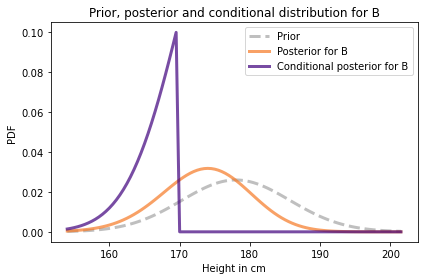

In [50]:
prior.plot(style='--', label='Prior', color='C5')
marginal_B.plot(label='Posterior for B', color='C1')
cond_B.plot(label='Conditional posterior for B', 
            color='C4')

decorate(xlabel='Height in cm',
         ylabel='PDF',
         title='Prior, posterior and conditional distribution for B')

La priorità condizionale è tagliata all'altezza di 170cm, in quanto abbiamo stabilito che `B` è più corto di `A` e `A` sia 170 cm.

## Dipendenza e indipendenza

Quando abbiamo costruito una distribuzione congiunta a priori, abbiamo detto che l'altezza di `A` e `B` sono indipendenti, questo significa che conoscendo conoscendo un valore non abbiamo informazioni relative agli altri.

In altre parole, la probabilità condizionale $P(A_x | B_y)$ è la stessa della probabilità non condizionale $P(A_x)$.
Ma se sappiamo che `A` è più alta di `B` e sappiamo quanto  `A` è alto, questo ci da informazioni circa `B`.

La distribuzione condizionale che abbiamo appena calcolato dimostra questa dipendenza. 

## Sommario

In questo capitolo, siamo partiti dalle operazioni "outer", come il prodotto esterno, che abbiamo usato per costruire una distribuzione congiunta.

In generale, non possiamo costruire una distribuire congiunta da due distribuzioni marginali, ma in casi speciali dove le distribuzioni sono indipendenti si può.

Possiamo estendere l'aggiornamento Bayesiano e applicarlo alle distribuzione congiunte. Poi dalla distribuzione a posteriori congiunti dove abbiamo estratto la distribuzione a posteriori marginale e la distribuzione condizionale.